# Exploring Pipelines and Evaluating Classification Models

## Why Pipeline?

Pipelines can keep our code neat and clean all the way from gathering & cleaning our data, to creating models & fine-tuning them!

**Advantages**: 
- Reduces complexity
- Convenient 
- Flexible 
- Can help prevent mistakes (like data leakage between train and test set) 

Easily integrate transformers and estimators, plus cross validation!

<img src="images/grid_search_cross_validation.png" alt="cross validation image from sklearn's documentation" width=500>



In [2]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve

First, let's start with the Titanic dataset from earlier today. Target is to predict `Survived`

In [3]:
# Grab, then explore data
df = pd.read_csv('data/titanic.csv')  

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Exploring numeric cols
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# Exploring object cols
df[[c for c in df.columns if df[c].dtype == 'object']].describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Moran, Mr. James",male,347082,B96 B98,S
freq,1,577,7,4,644


### Baseline Understanding - Aka Model-less Baseline

In [8]:
# Exploring target distribution
df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

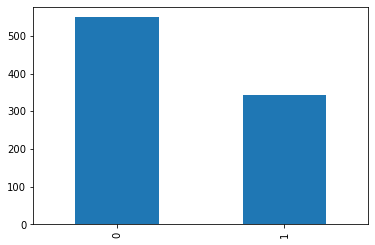

In [9]:
df['Survived'].value_counts().plot(kind='bar');

Evaluate - any thoughts on our model-less understanding?

- If we assume no one survives the Titanic we're right 61% of the time - accuracy


### Baseline Model

Let's find out how hard our problem is, by throwing things at it and seeing what sticks!

Biggest thing to think about - what types of columns need to be treated differently?

Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [10]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
# First define our used columns
# Let's not use ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived']
used_cols = [c for c in df.columns if c not in ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived']]

# used_cols = []
# for c in df.columns:
#     if c not in ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived']:
#         used_cols.append(c)

In [12]:
used_cols

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [13]:
# Define our X and y

X = df[used_cols]
y = df['Survived']

# and train test split - to create our val holdout set!
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.15,
                                                    random_state=0)

In [15]:
# Set up lists for columns requiring different treatment
num_cols = []
cat_cols = []

for c in used_cols:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        cat_cols.append(c)

In [16]:
# Check our work
print(num_cols)
print(cat_cols)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
['Sex', 'Embarked']


In [18]:
# Now, setting up the preprocessing steps for each type of col
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

cat_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [26]:
# Package those pieces together using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [27]:
# Just out of curiosity, let's see what this looks like 
X_tr_transformed = preprocessor.fit_transform(X_train)
X_tr_transformed.shape

(757, 11)

In [28]:
pd.DataFrame(X_tr_transformed)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.798311,0.000,0.000000,0.050749,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.256271,0.000,0.000000,0.015713,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.357116,0.125,0.000000,0.015127,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,0.495777,0.125,0.000000,0.018494,1.0,0.0,0.0,0.0,1.0,0.0
4,0.5,0.546199,0.125,0.000000,0.050749,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
752,0.0,0.483172,0.125,0.166667,0.162314,1.0,0.0,1.0,0.0,0.0,0.0
753,1.0,0.231060,0.125,0.000000,0.015330,1.0,0.0,0.0,0.0,1.0,0.0
754,1.0,0.357116,0.000,0.000000,0.015094,0.0,1.0,0.0,1.0,0.0,0.0
755,1.0,0.445355,0.125,0.000000,0.033963,1.0,0.0,0.0,0.0,1.0,0.0


In [30]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked'])])

In [31]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=5))
])

In [38]:
# Now - cross_validate!
output = cross_validate(clf, X_train, y_train, cv=3, scoring=['accuracy', 'roc_auc'])

# Print our test scores to show average and a measure of variation
print(f"Average Accuracy: {output['test_accuracy'].mean()} +/- {output['test_accuracy'].std()}")
print(f"Average ROC-AUC: {output['test_roc_auc'].mean()} +/- {output['test_roc_auc'].std()}")

Average Accuracy: 0.7979013739883305 +/- 0.0166398338923268
Average ROC-AUC: 0.8500116497342969 +/- 0.02235041212719477


In [37]:
output

{'fit_time': array([0.03004909, 0.03500605, 0.03888202]),
 'score_time': array([0.01679492, 0.02409792, 0.01695585]),
 'test_accuracy': array([0.78656126, 0.78571429, 0.82142857]),
 'test_roc_auc': array([0.84434713, 0.82591351, 0.87977431])}

Evaluate:

- 


### Try With Adjusted Hyperparameters

In [40]:
y.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [41]:
# Time for a new pipeline!
clf_bal = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=5,
                                      class_weight='balanced'))
])

output = cross_validate(clf_bal, X_train, y_train, cv=3, scoring=['accuracy', 'roc_auc'])

# Print our test scores to show average and a measure of variation
print(f"Average Accuracy: {output['test_accuracy'].mean()} +/- {output['test_accuracy'].std()}")
print(f"Average ROC-AUC: {output['test_roc_auc'].mean()} +/- {output['test_roc_auc'].std()}")

Average Accuracy: 0.7767739506869941 +/- 0.028839779273550907
Average ROC-AUC: 0.8505705325488786 +/- 0.021181393033853396


Evaluate:

- 


In [42]:
clf_bal

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('oh

### Validate

How does this perform on our holdout set?

First off - what might we want to check to evaluate our model?

- Confusion matrix
- Accuracy, precision, recall, f1-score
- Roc-Auc


Reference: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [43]:
# Can use a pipeline we defined earlier, but need to fit it
clf_bal.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('oh

In [49]:
# Grab predictions
train_preds = clf_bal.predict(X_train)
hold_preds = clf_bal.predict(X_hold)

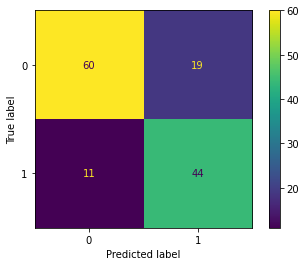

In [50]:
# What do we want to check first?
plot_confusion_matrix(clf_bal, X_hold, y_hold)

In [53]:
# More space to check more metrics
print("Training Scores:")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Train Precision: {precision_score(y_train, train_preds)}")
print(f"Train Recall: {recall_score(y_train, train_preds)}")
print(f"Train F1-Score: {f1_score(y_train, train_preds)}")
print("*" * 10)
print("Hold Out Scores:")
print(f"Test Accuracy: {accuracy_score(y_hold, hold_preds)}")
print(f"Test Precision: {precision_score(y_hold, hold_preds)}")
print(f"Test Recall: {recall_score(y_hold, hold_preds)}")
print(f"Test F1-Score: {f1_score(y_hold, hold_preds)}")

Training Scores:
Train Accuracy: 0.7780713342140027
Train Precision: 0.6925566343042071
Train Recall: 0.7456445993031359
Train F1-Score: 0.7181208053691275
**********
Hold Out Scores:
Test Accuracy: 0.7761194029850746
Test Precision: 0.6984126984126984
Test Recall: 0.8
Test F1-Score: 0.7457627118644068


In [58]:
# ROC-AUC IS DIFFERENT
train_probas = clf_bal.predict_proba(X_train)[:,1]
hold_probas = clf_bal.predict_proba(X_hold)[:,1]

In [56]:
train_preds

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,

In [59]:
train_probas

array([0.31076937, 0.19363946, 0.17400923, 0.58782821, 0.20945854,
       0.3628632 , 0.33084196, 0.93830209, 0.16073   , 0.80729257,
       0.85580038, 0.72868139, 0.31844051, 0.77331304, 0.93511594,
       0.16079101, 0.40189909, 0.69443026, 0.65039882, 0.16070262,
       0.92822631, 0.34306692, 0.69092712, 0.15870602, 0.75438269,
       0.84525427, 0.16071465, 0.28012467, 0.9075315 , 0.54883503,
       0.26270605, 0.17654036, 0.09314764, 0.18923251, 0.18071669,
       0.21199462, 0.09320975, 0.93964055, 0.16065035, 0.16137335,
       0.85231617, 0.16073   , 0.95139341, 0.18493765, 0.20262557,
       0.77010827, 0.31193734, 0.36678625, 0.27964606, 0.19354726,
       0.43255809, 0.18926131, 0.75440036, 0.32251002, 0.17247929,
       0.8405374 , 0.70943726, 0.49379649, 0.84505249, 0.75438098,
       0.20155357, 0.40325926, 0.16073   , 0.80386627, 0.51309874,
       0.09757775, 0.20723386, 0.75487943, 0.13077074, 0.82443648,
       0.20262557, 0.38256421, 0.6492731 , 0.14963987, 0.81604

In [61]:
print("Training Scores:")
print(f"Train ROC-AUC: {roc_auc_score(y_train, train_probas)}")
print("*" * 10)
print("Hold Out Scores:")
print(f"Test ROC_AUC: {roc_auc_score(y_hold, hold_probas)}")

Training Scores:
Train ROC-AUC: 0.8539217139891764
**********
Hold Out Scores:
Test ROC_AUC: 0.865132336018412


### Now - Let's Build an Evaluate Function for Classification!

In [ ]:
# plot_confusion_matrix()

In [62]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te):
    '''
    
    '''
    # Grab predictions
    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)
    
    print("Training Scores:")
    print(f"Train Accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train Precision: {precision_score(y_tr, tr_preds)}")
    print(f"Train Recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train F1-Score: {f1_score(y_tr, tr_preds)}")
    print("*" * 10)
    print("Hold Out Scores:")
    print(f"Test Accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test Precision: {precision_score(y_te, te_preds)}")
    print(f"Test Recall: {recall_score(y_te, te_preds)}")
    print(f"Test F1-Score: {f1_score(y_te, te_preds)}")
    
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(estimator, X_te, y_te)

Training Scores:
Train Accuracy: 0.7780713342140027
Train Precision: 0.6925566343042071
Train Recall: 0.7456445993031359
Train F1-Score: 0.7181208053691275
**********
Hold Out Scores:
Test Accuracy: 0.7761194029850746
Test Precision: 0.6984126984126984
Test Recall: 0.8
Test F1-Score: 0.7457627118644068


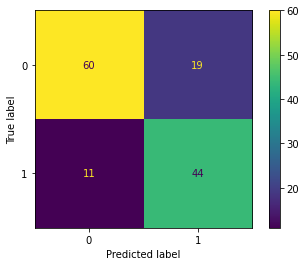

In [63]:
# Use our evaluate function!
evaluate(clf_bal, X_train, X_hold, y_train, y_hold)

### Bonus Visualization

Code originated from: https://stackoverflow.com/questions/45715018/scikit-learn-how-to-plot-probabilities

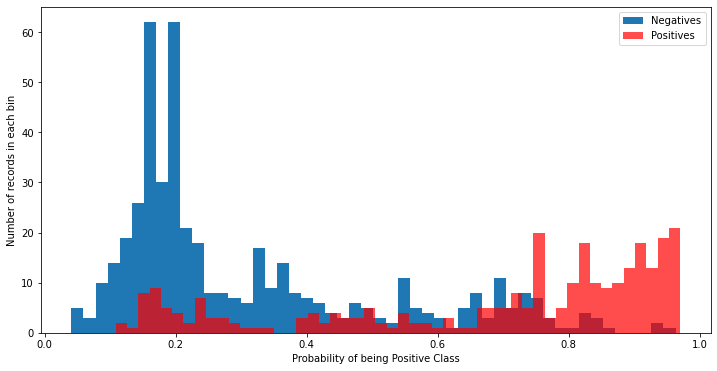

In [64]:
# A bonus, for making it to the end of the notebook...
train_target = pd.DataFrame(y_train) # Create a df with our actual train y values
# Add the predicted probabilities for 1 as a column
train_target['Predicted Probability'] = clf_bal.predict_proba(X_train)[:,1]

# Plot the two
plt.figure(figsize=(12,6))
plt.hist(train_target[train_target['Survived']==0]['Predicted Probability'], 
         bins=50, label='Negatives')
plt.hist(train_target[train_target['Survived']==1]['Predicted Probability'], 
         bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bin')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

## Level Up - What to do with too many options in categorical columns?

Data we can use for this: https://www.kaggle.com/c/cat-in-the-dat-ii (this file is in this github repo, in the data folder)

New library you can install with more encoding techniques: https://contrib.scikit-learn.org/category_encoders/

- (these work within SKLearn pipelines, since they're written in the SKLearn style!)


## Resources

Check out Aurélien Geron's notebook of an [end-to-end ml project](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on his GitHub repo based around his book [_Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed)_](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)